In [1]:
import cv2
import numpy as np
import os 

from skimage.feature import peak_local_max
#from skimage.morphology import watershed
from scipy import ndimage
from scipy.signal import find_peaks

# My custom library of photoelastic tools
import sys
sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')

from pepe.preprocess import crossMask, checkImageType, circularMask, lightCorrectionDiff
from pepe.preprocess import cannyEdgeDetection, laplacianEdgeDetection, sobelEdgeDetection, applyFilter

from pepe.analysis import gSquared
from pepe.tracking import houghCircle, kernelFind, circularKernelFind

from pepe.topology import findPeaks

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

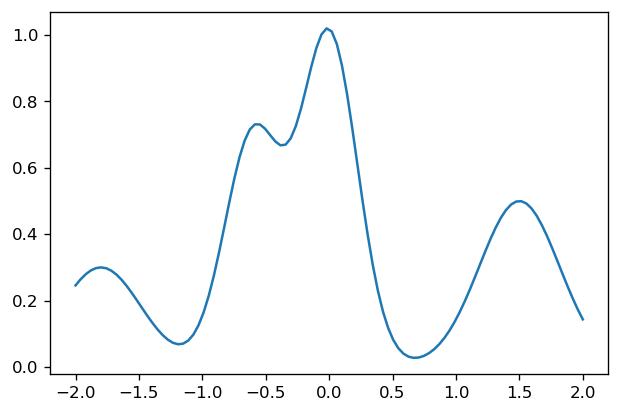

In [2]:
xArr = np.linspace(-2, 2, 100)
data = np.exp(-xArr**2*10) + .5*np.exp(-5*(xArr-1.5)**2) + .3*np.exp(-5*(xArr+1.8)**2) + .7*np.exp(-10*(xArr+.6)**2)

plt.plot(xArr, data)

In [3]:
class Peak:
    def __init__(self, startidx):
        self.born = self.left = self.right = startidx
        self.died = None

    def get_persistence(self, seq):
        return float("inf") if self.died is None else seq[self.born] - seq[self.died]

def get_persistent_homology(seq):
    peaks = []
    # Maps indices to peaks
    idxtopeak = [None for s in seq]
    # Sequence indices sorted by values
    indices = range(len(seq))
    indices = sorted(indices, key = lambda i: seq[i], reverse=True)

    # Process each sample in descending order
    for idx in indices:
        lftdone = (idx > 0 and idxtopeak[idx-1] is not None)
        rgtdone = (idx < len(seq)-1 and idxtopeak[idx+1] is not None)
        il = idxtopeak[idx-1] if lftdone else None
        ir = idxtopeak[idx+1] if rgtdone else None

        # New peak born
        if not lftdone and not rgtdone:
            peaks.append(Peak(idx))
            idxtopeak[idx] = len(peaks)-1

        # Directly merge to next peak left
        if lftdone and not rgtdone:
            peaks[il].right += 1
            idxtopeak[idx] = il

        # Directly merge to next peak right
        if not lftdone and rgtdone:
            peaks[ir].left -= 1
            idxtopeak[idx] = ir

        # Merge left and right peaks
        if lftdone and rgtdone:
            print('merging')
            # Left was born earlier: merge right to left
            if seq[peaks[il].born] > seq[peaks[ir].born]:
                print('left')
                peaks[ir].died = idx
                peaks[il].right = peaks[ir].right
                idxtopeak[peaks[il].right] = idxtopeak[idx] = il
            else:
                print('right')
                peaks[il].died = idx
                peaks[ir].left = peaks[il].left
                idxtopeak[peaks[ir].left] = idxtopeak[idx] = ir

    # This is optional convenience
    return sorted(peaks, key=lambda p: p.get_persistence(seq), reverse=True)

In [4]:
a = np.array([1, 3, 2, 3, 5, 7, 8, 4, 3, 2, 7])
b = np.array([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1])
a[b == 1]

array([3, 7, 8, 3, 7])

In [5]:
findPeaks(data)

(array([49, 87,  5, 35]),
 array([1.        , 0.4744736 , 0.2288785 , 0.05214427]))

In [6]:
[get_persistent_homology(data)[i].get_persistence(data) for i in range(4)]

merging
right
merging
right
merging
left
merging
right
merging
right
merging
left
merging
right
merging
right
merging
left
merging
right
merging
right
merging
left


[inf, 0.47215872529113906, 0.23170590467607477, 0.06322327099558045]

In [2]:
def genTrainingImages(imgSize, N, minCircles=1, maxCircles=4, minRadius=125, maxRadius=200, overlap=False, noise=1):
    img = np.zeros((N, *imgSize))
    numCircles = np.random.randint(minCircles, maxCircles, size=N)
    
    circleCentersX = np.random.randint(0, imgSize[0], size=N)
    circleCentersY = np.random.randint(0, imgSize[1], size=N)
    
    Y = np.arange(imgSize[0]).reshape((imgSize[0], 1)) # Column vector
    X = np.arange(imgSize[1]).reshape((1, imgSize[1])) # Row vector
    
    # Generate the circles
    for i in range(N):
        radii = np.random.uniform(minRadius, maxRadius, size=numCircles[i])
        j = 0
        while j < numCircles[i]:
            yC, xC = np.random.randint(0, imgSize[0]), np.random.randint(0, imgSize[1])
            newCircle = ((X - xC)**2 + (Y - yC)**2) < radii[j]**2
            # Make sure circles don't overlap
            if np.max(img[i] + newCircle) == 1:
                img[i] += newCircle
                j += 1
                
    # Now add noise
    noisyImg = img + np.random.uniform(0.01*noise, noise, size=img.shape)
    
    return noisyImg, img, (yC, xC)

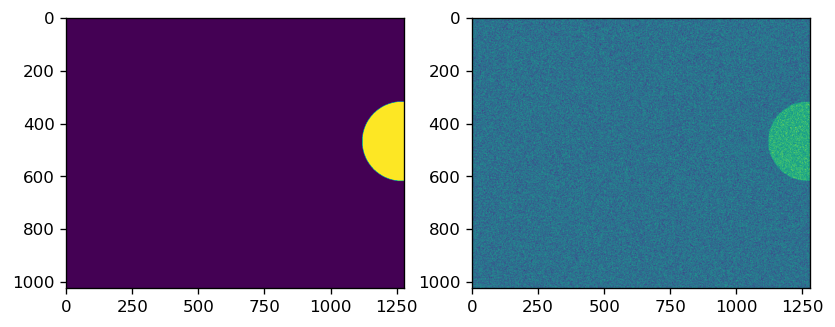

In [3]:
noisyImg, img, center = genTrainingImages((1024, 1280), 1, minCircles=1, maxCircles=2, noise=3, minRadius=150, maxRadius=150)

fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].imshow(img[0])
ax[1].imshow(noisyImg[0])
plt.savefig('test_img.png')
plt.show()

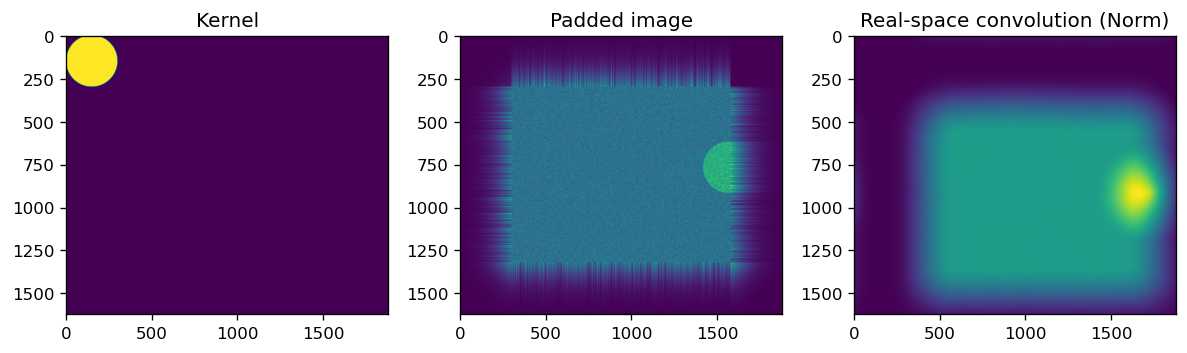

In [4]:
radius = 150
costArr = circularKernelFind(noisyImg[0], 150, debug=True, fftPadding=300)
maxPoints = np.where(costArr == np.max(costArr))
maxPoints = (maxPoints[0][0], maxPoints[1][0])
#costArr = convCircle(image[:,:,0]*maskArr[:,:,0], radius, fftPadding=1)

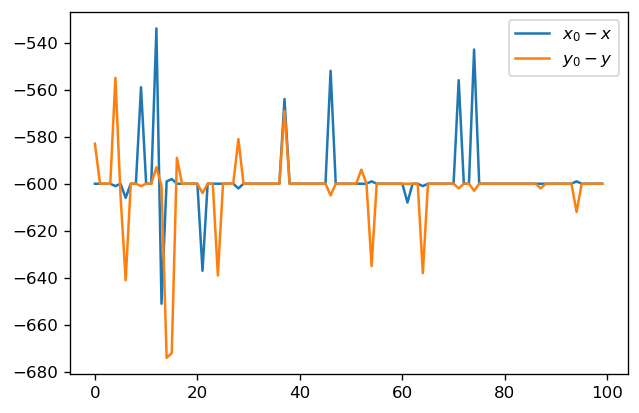

In [6]:
xDiffArr = np.zeros(100)
yDiffArr = np.zeros(100)

radius = 150

for i in range(100):
    noisyImg, img, center = genTrainingImages((1024, 1280), 1, minCircles=1, maxCircles=2, noise=5, minRadius=150, maxRadius=150)
    costArr = circularKernelFind(noisyImg[0], radius, debug=False, fftPadding=int(radius*3))
    maxPoint = np.where(costArr == np.max(costArr))
    maxPoint = (maxPoint[0][0], maxPoint[1][0])
    
    yDiffArr[i] = center[0] - maxPoint[0]
    xDiffArr[i] = center[1] - maxPoint[1]
    
plt.plot(yDiffArr, label='$x_0 - x$')
plt.plot(xDiffArr, label='$y_0 - y$')
plt.legend()
plt.savefig('offset.png')
plt.show()

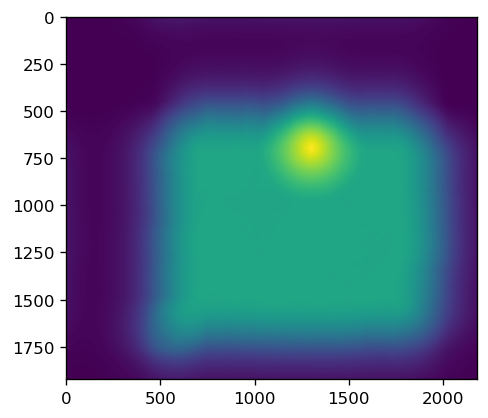

In [35]:
plt.imshow(np.abs(costArr))

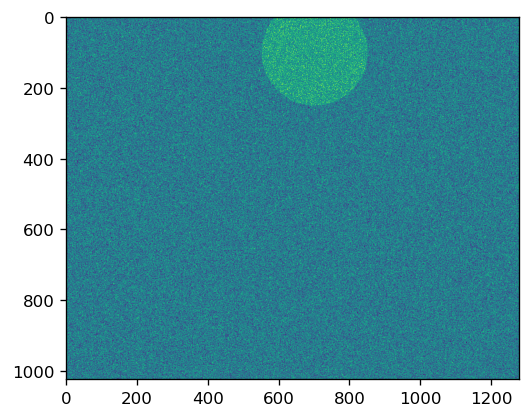

In [39]:
plt.imshow(noisyImg[0])

In [38]:
find_peaks(costArr)

/home/jack/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


ValueError: `x` must be a 1-D array